In [154]:
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("darkgrid")
import scipy
from scipy import stats
from scipy import signal
from itertools import *
sns.plt = plt
np.random.seed(1) # No estoy seguro si es necesario

In [155]:
# Carga de datos

# datasets_sujetos: (Sujeto x Epoch x Electrodo x Tiempo -> Valor)
datasets_sujetos = []

# Solo 2 datasets, para probar
datasets_sujetos.append(scipy.io.loadmat('datos/S01.mat')['data'])
datasets_sujetos.append(scipy.io.loadmat('datos/P01.mat')['data'])

# # Normales
# for i in range(1,10):
#     datasets_sujetos.append(scipy.io.loadmat('datos/S0'+str(i)+'.mat')['data'])
# datasets_sujetos.append(scipy.io.loadmat('datos/S10.mat')['data'])

# # Disminuidos
# for i in range(1,10):
#     datasets_sujetos.append(scipy.io.loadmat('datos/P0'+str(i)+'.mat')['data'])
# datasets_sujetos.append(scipy.io.loadmat('datos/P10.mat')['data'])

In [156]:
print 'Se cargaron '+ str(len(datasets_sujetos)) + ' datasets.'

Se cargaron 2 datasets.


In [157]:
# Dado un dataset de (Epoch x Electrodo x Tiempo -> Valor) devuelve
# otro de la misma forma pero solo con los electrodos importantes
def electrodos_importantes(dataset):
    return dataset[:, [7, 43, 79, 130, 184], :]

In [168]:
# Dado un dataset de (Epoch x Electrodo x Tiempo -> Valor)
# devuelve la cantidad de epochs
def epoch_count(dataset):
    return len(dataset)

# Dado un dataset de (Epoch x Electrodo x Tiempo -> Valor)
# devuelve la cantidad de electrodos
def electrodos_count(dataset):
    return len(dataset[0])

# Dado un dataset de (Epoch x Electrodo x Tiempo -> Valor)
# devuelve la cantidad de tiempos
def tiempo_count(dataset):
    return len(dataset[0][0])

# Dado un dataset de (Epoch x Electrodo x Tiempo -> Valor) devuelve una lista de 
# (Epoch x Tiempo -> Valor) promediando para cada epoch y tiempo, los valores de los electrodo
def average_by_epoch(dataset):
    return [[np.mean(dataset[epoch,:,tiempo]) 
             for tiempo in range(tiempo_count(dataset))] 
            for epoch in range(epoch_count(dataset))]

In [159]:
# Dada una lista zipeada de [(a,b)] devuelve una tupla de lista ([a],[b])
def unzip(iterable):
    return zip(*iterable)

# Dadas dos listas de freqs y pots emparentadas devuelve las listas
# sacando los pares donde las frecuencias son mayores a 45.0
def freq_pots_relevantes(freqs, pots):
    pairs_relevantes = filter(lambda x: x[0] <= 45.0, zip(freqs, pots))
    return unzip(pairs_relevantes)

In [160]:
def graph_fft(dataset):
    averaged_electrodes_by_epoch = average_by_epoch(dataset)
    allEpochs = pd.DataFrame([]);
    for i in range(epoch_count(dataset)):
        epoch_welch = scipy.signal.welch(averaged_electrodes_by_epoch[i], fs=250)
        (freqs_relevantes, pots_relevantes) = freq_pots_relevantes(epoch_welch[0], epoch_welch[1])
        allEpochs = allEpochs.append(pd.DataFrame([pots_relevantes], columns=freqs_relevantes))
    allEpochs = allEpochs.reset_index();
    ax = sns.heatmap(allEpochs.transpose(), cmap="viridis", fmt='.2g')
    ax.set_ylabel('Frecuencia')
    ax.set_xlabel('Epoch')
    for label in ax.get_xticklabels()[::2]:
        label.set_visible(False)
    ax.set_yticklabels([item.get_text()[0:4] for item in ax.get_yticklabels()])
    plt.rcParams['figure.figsize'] = 14, 6
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.show()
    del allEpochs

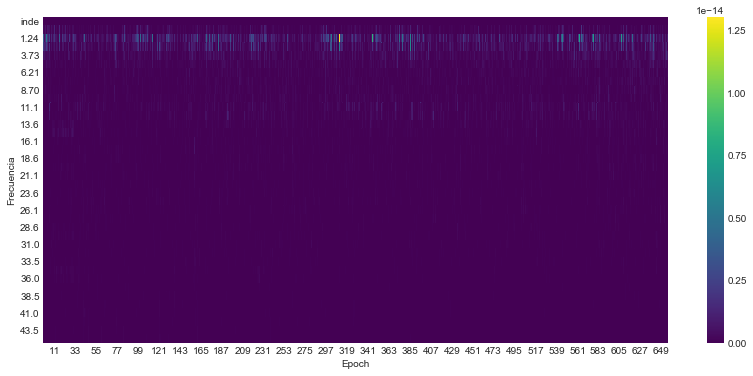

In [161]:
graph_fft(datasets_sujetos[0])

In [217]:
def get_epoch(epoch_idx,electrodo_idx, dataset):
    return dataset[epoch_idx, electrodo_idx, :]

def par_frecuencias_potencias_epoch(epoch_idx,electrodo_idx,dataset):
    welch_result = scipy.signal.welch(get_epoch(epoch_idx,electrodo_idx,dataset), fs=250)
    return freq_pots_relevantes(welch_result[0], welch_result[1])

# Dado un dataset y un electrodo devuelve una lista de potencias promedio para cada epoch
def potencias_promedio(electrodo_idx,dataset):
    freqs_pots_por_epoch = [par_frecuencias_potencias_epoch(i,electrodo_idx, dataset) for i in range(epoch_count(dataset))]
    res = pd.DataFrame([])
    for i in range(len(freqs_pots_por_epoch)):
        res = res.append(pd.DataFrame([freqs_pots_por_epoch[i][1]], columns=freqs_pots_por_epoch[i][0]))
    return res.mean()

def graph_potencias(dataset):
    colors = sns.color_palette('muted', n_colors=electrodos_count(dataset))
    for i in range(electrodes_count(dataset)):
        sns.tsplot(potencias_promedio(i, dataset), color=colors[i])
    plt.show()

In [ ]:
graph_potencias(datasets_sujetos[0])

In [171]:
def potencia_banda(low, high, potencias_promedio, frecuencias):
    # Thomas dice np.average
    return np.average(map(lambda x: x[0], ifilter(lambda x: x[1] >= low and x[1] < high, izip(potencias_promedio, frecuencias))))

def get_bandas_dict(dataset):
    potencias_promedio_by_electrode = []
    for i in range(electrodes_count(dataset)):
        potencias_promedio_by_electrode.append(potencias_promedio(i, dataset))
    potencias_promedio_total = [np.average([potencias_promedio_by_electrode[j][i] for j in range(len(potencias_promedio_by_electrode))]) for i in range(len(potencias_promedio_by_electrode[0]))]
    del potencias_promedio_by_electrode
    frecuencias = par_frecuencias_potencias_epoch(0,0, dataset)[0]
    res = {}
    res['delta'] = potencia_banda(0., 4.0, potencias_promedio_total, frecuencias)
    res['theta'] = potencia_banda(4.0, 8.0, potencias_promedio_total, frecuencias)
    res['alpha'] = potencia_banda(8.0, 13.0, potencias_promedio_total, frecuencias)
    res['beta'] = potencia_banda(13.0, 30., potencias_promedio_total, frecuencias)
    res['gamma'] = potencia_banda(30.0, 125., potencias_promedio_total, frecuencias)
    
    return res

In [179]:
bandas_frame_columns = ['delta','theta','alpha','beta','gamma','tipo']
bandas_frame = pd.DataFrame(data=[], columns=bandas_frame_columns)

for dataset_index in range(len(datasets_sujetos)):
    bandas_dict = get_bandas_dict(datasets_sujetos[dataset_index])
    if dataset_index + 1 < len(datasets_sujetos):
        bandas_dict['tipo'] = 'normal'
    else:
        bandas_dict['tipo'] = 'disminuido'
    bandas_sujeto = pd.DataFrame(data=[bandas_dict], columns=bandas_frame_columns)
    bandas_frame = bandas_frame.append(bandas_sujeto)

In [180]:
print bandas_frame

          delta         theta         alpha          beta         gamma  \
0  2.982860e-12  8.169761e-13  6.708537e-13  3.538571e-13  2.067432e-13   
0  6.563069e-12  1.246806e-12  4.485051e-13  1.983459e-13  1.604475e-13   

         tipo  
0      normal  
0  disminuido  


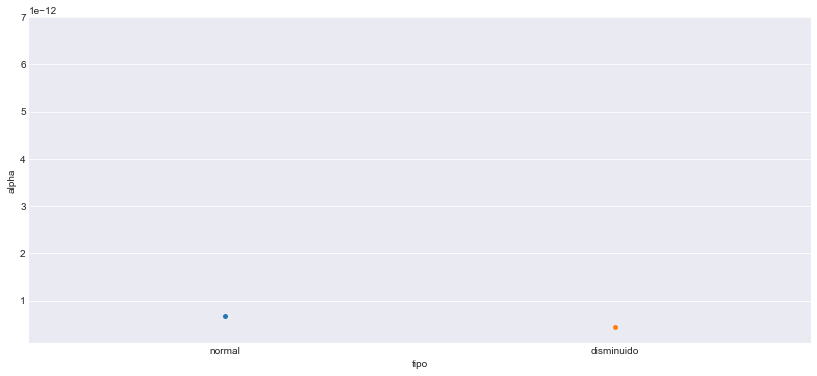

In [181]:
sns.stripplot(data=bandas_frame, y="alpha", x="tipo")
plt.ylim(1e-13, 7e-12)
plt.show()


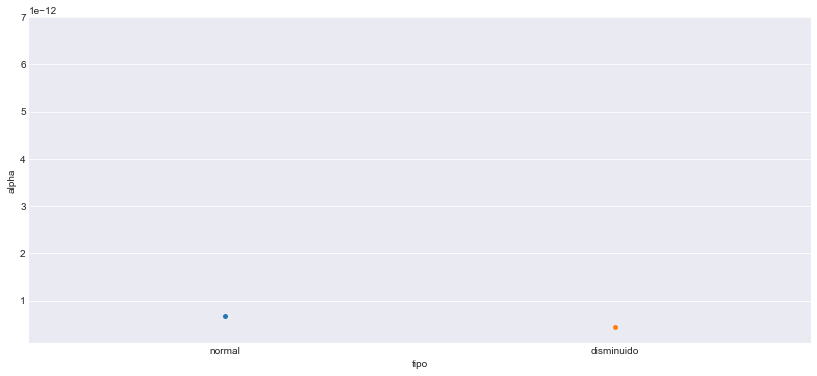

In [182]:
sns.swarmplot(x="tipo", y="alpha", data=bandas_frame)
plt.ylim(1e-13, 7e-12)
plt.show()

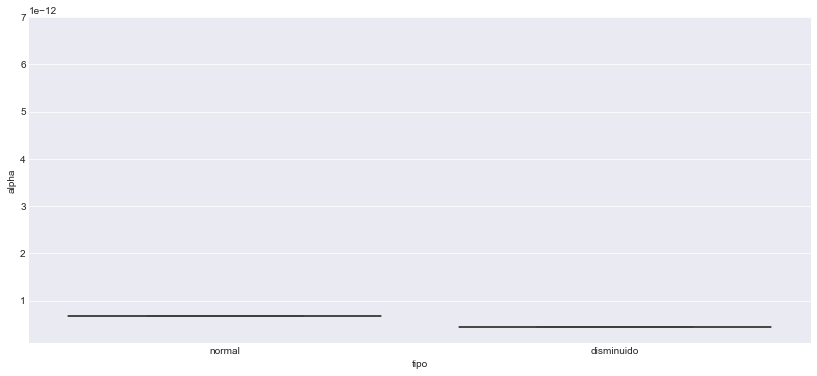

In [183]:
sns.boxplot(x="tipo", y="alpha", data=bandas_frame)
plt.ylim(1e-13, 7e-12)
plt.show()

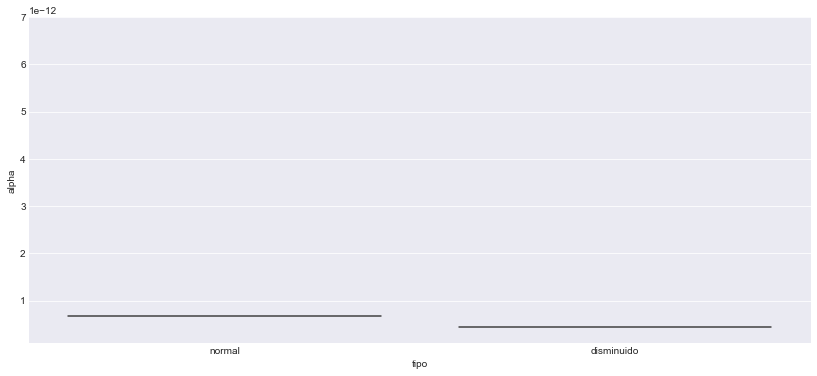

In [184]:
sns.violinplot(x="tipo", y="alpha", data=bandas_frame)
plt.ylim(1e-13, 7e-12)
plt.show()

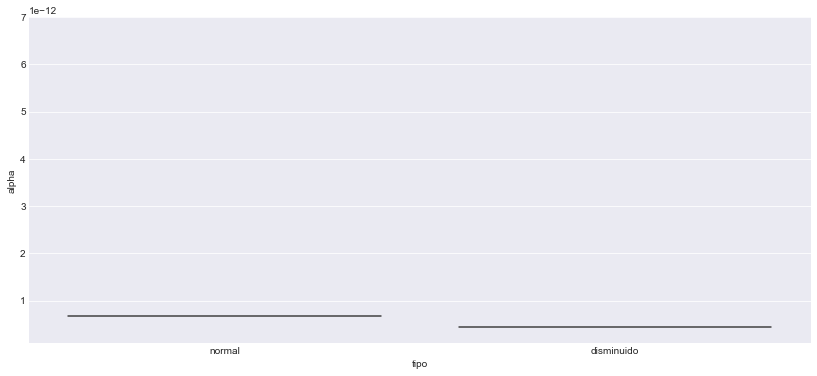

In [185]:
sns.lvplot(x="tipo", y="alpha", data=bandas_frame)
plt.ylim(1e-13, 7e-12)
plt.show()

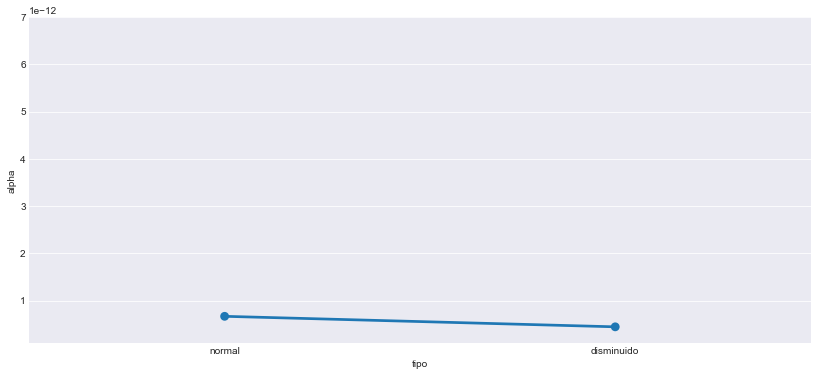

In [186]:
sns.pointplot(x="tipo", y="alpha", data=bandas_frame)
plt.ylim(1e-13, 7e-12)
plt.show()

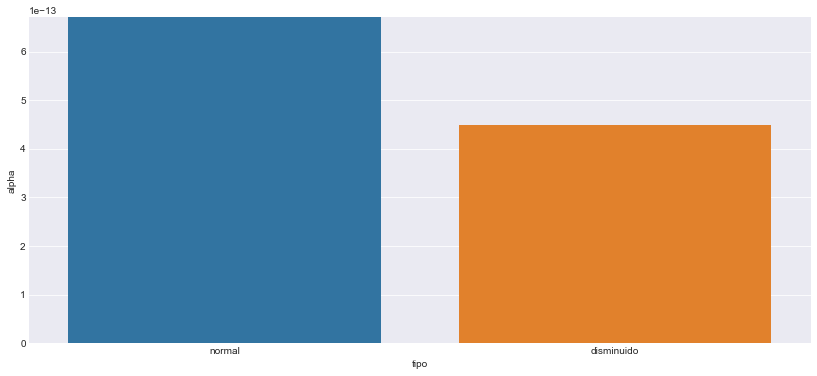

In [187]:
sns.barplot(x="tipo", y="alpha", data=bandas_frame)
plt.show()

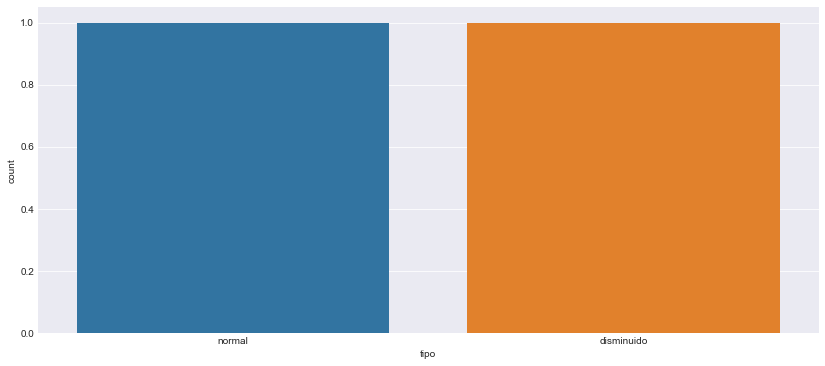

In [188]:
sns.countplot(x="tipo" ,data=bandas_frame)
plt.show()


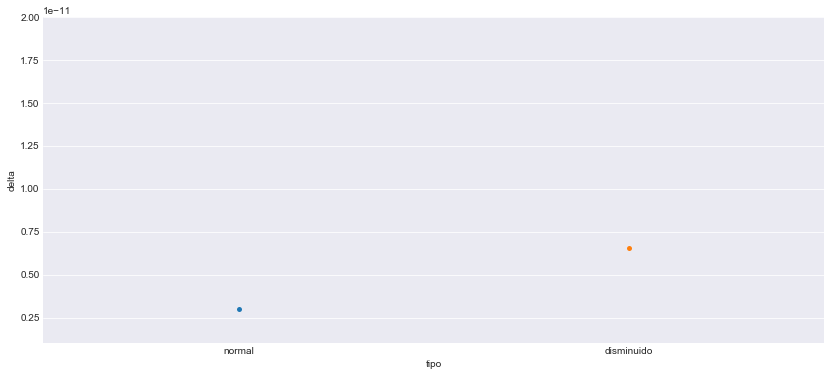

In [189]:
sns.swarmplot(x="tipo", y="delta", data=bandas_frame)
plt.ylim(1e-12, 2e-11)
plt.show()

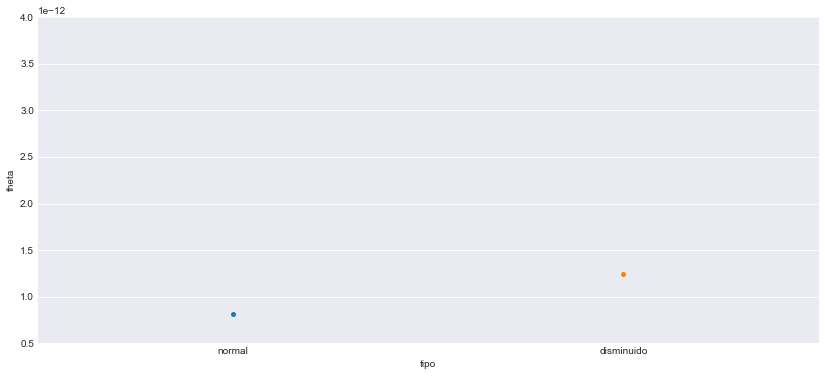

In [190]:
sns.swarmplot(x="tipo", y="theta", data=bandas_frame)
plt.ylim(5e-13, 4e-12)
plt.show()

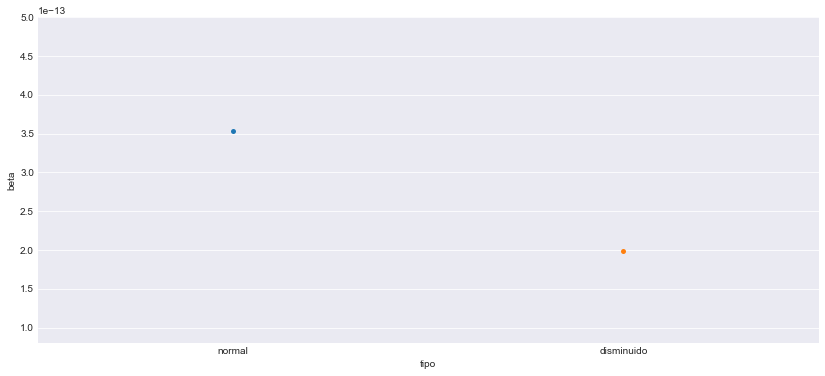

In [191]:
sns.swarmplot(x="tipo", y="beta", data=bandas_frame)
plt.ylim(8e-14, 5e-13)
plt.show()

In [192]:
print bandas_frame

          delta         theta         alpha          beta         gamma  \
0  2.982860e-12  8.169761e-13  6.708537e-13  3.538571e-13  2.067432e-13   
0  6.563069e-12  1.246806e-12  4.485051e-13  1.983459e-13  1.604475e-13   

         tipo  
0      normal  
0  disminuido  


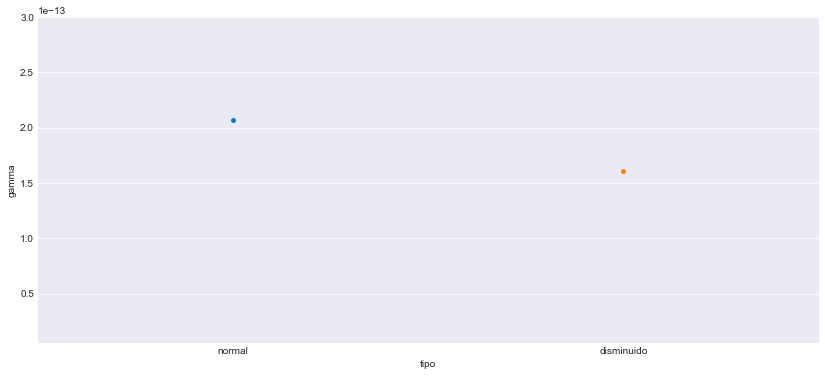

In [193]:
sns.swarmplot(x="tipo", y="gamma", data=bandas_frame)
plt.ylim(5e-15, 3e-13)
plt.show()